# Model 1: Custom CNN from Scratch

## Imports

In [18]:
!pip install torchinfo

In [19]:
import kagglehub
import zipfile
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2
from torchinfo import summary
from tqdm.auto import tqdm
import torch.optim as optim
import time
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report

## Download Dataset

In [20]:
path = kagglehub.dataset_download("alsaniipe/chest-x-ray-image")

print("Path to dataset files:", path)

os.listdir(path)

Path to dataset files: /kaggle/input/chest-x-ray-image


['Data']

## Visualization

Directory: /kaggle/input/chest-x-ray-image/Data/train

Classes: ['PNEUMONIA', 'NORMAL', 'COVID19']



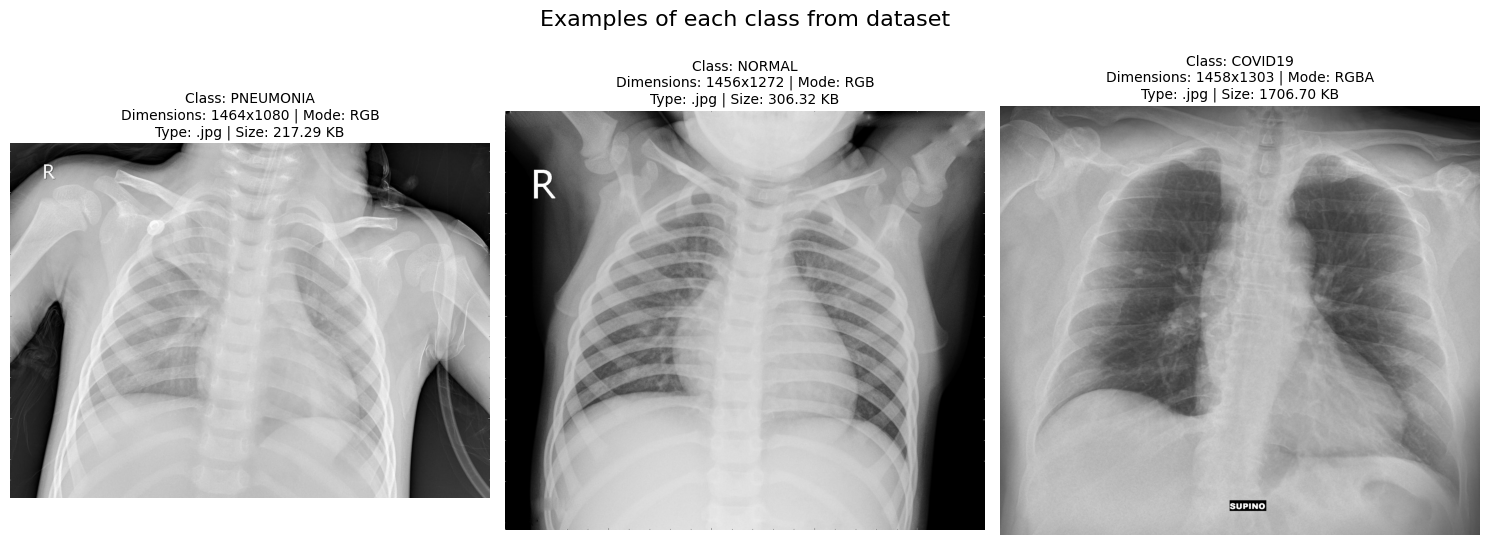

In [21]:
base_path = '/kaggle/input/chest-x-ray-image'
data_dir = os.path.join(base_path, 'Data')
train_dir = os.path.join(data_dir, 'train')

print(f"Directory: {train_dir}\n") # check the directory

classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
print(f"Classes: {classes}\n") # check classes

num_classes = len(classes)
plt.figure(figsize=(15, 6))

for i, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)

    random_image_name = random.choice(os.listdir(class_dir))
    image_path = os.path.join(class_dir, random_image_name)

    file_size_kb = os.path.getsize(image_path) / 1024
    file_type = os.path.splitext(random_image_name)[1]

    with Image.open(image_path) as img:
        width, height = img.size
        mode = img.mode

        ax = plt.subplot(1, num_classes, i + 1)
        plt.imshow(img, cmap='gray')

        title_text = (
            f"Class: {class_name}\n"
            f"Dimensions: {width}x{height} | Mode: {mode}\n"
            f"Type: {file_type} | Size: {file_size_kb:.2f} KB"
        )
        plt.title(title_text, fontsize=10)
        plt.axis('off')

plt.suptitle("Examples of each class from dataset", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Train, validation and test dataset

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando o dispositivo: {device}") # check

test_dir = os.path.join(data_dir, 'test')

IMG_SIZE = 224
BATCH_SIZE = 32
TRAIN_RATIO = 0.8

def load_img(path):
    img = Image.open(path).convert('RGB') # make sure that the image have the three channels
    img = v2.functional.to_image(img) # convert to a pytorch tensor
    img = v2.functional.to_dtype(img, dtype=torch.uint8, scale=True) # make sure that the image has 8 bits
    return img

minimal_transforms = v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)), # all images become 244 x 244
    v2.ToDtype(torch.float32, scale=True) # transform in a float between 0 and 1
])

initial_train_dataset = ImageFolder(root=train_dir, transform=minimal_transforms, loader=load_img)
test_dataset = ImageFolder(root=test_dir, transform=minimal_transforms, loader=load_img)

class_names = initial_train_dataset.classes

num_train_samples = len(initial_train_dataset)
train_size = int(num_train_samples * TRAIN_RATIO)
val_size = num_train_samples - train_size

train_dataset, val_dataset = random_split(initial_train_dataset, [train_size, val_size])
print(f"\nTrain dataset: {len(train_dataset)}\nValidation dataset: {len(val_dataset)}.")

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Usando o dispositivo: cuda

Train dataset: 4115
Validation dataset: 1029.


## Data augmentation

In [23]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.ColorJitter(brightness=0.2, contrast=0.2),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

train_dataset.dataset.transform = train_transforms # only on train dataset

## Transformations for validation and test

In [24]:
val_test_transforms = v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

val_dataset.dataset.transform = val_test_transforms
test_dataset.transform = val_test_transforms

## Dataloaders

In [25]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle in each epoch
    num_workers=2, # paralelization
    pin_memory=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Batches in train_loader: {len(train_loader)}")
print(f"Batches in val_loader: {len(val_loader)}")
print(f"Batches in test_loader: {len(test_loader)}")

Batches in train_loader: 129
Batches in val_loader: 33
Batches in test_loader: 41


## Architecture of the model

In this step, we define the architecture for our custom CNN. It consists of three convolutional blocks for feature extraction and a classifier head with a dropout layer to prevent overfitting.

In [26]:
NUM_CLASSES = 3

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            # first layer
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Image -> 112x112

            # second layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Image -> 56x56

            # third layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Imagem -> 28x28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # 64 x 28 x 28
            nn.Linear(in_features=64 * 28 * 28, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.5), # Dropout
            nn.Linear(in_features=512, out_features=num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

custom_model = CustomCNN(num_classes=NUM_CLASSES)

custom_model.to(device)

# check the model
summary(custom_model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
CustomCNN                                [32, 3]                   --
├─Sequential: 1-1                        [32, 64, 28, 28]          --
│    └─Conv2d: 2-1                       [32, 16, 224, 224]        448
│    └─BatchNorm2d: 2-2                  [32, 16, 224, 224]        32
│    └─ReLU: 2-3                         [32, 16, 224, 224]        --
│    └─MaxPool2d: 2-4                    [32, 16, 112, 112]        --
│    └─Conv2d: 2-5                       [32, 32, 112, 112]        4,640
│    └─BatchNorm2d: 2-6                  [32, 32, 112, 112]        64
│    └─ReLU: 2-7                         [32, 32, 112, 112]        --
│    └─MaxPool2d: 2-8                    [32, 32, 56, 56]          --
│    └─Conv2d: 2-9                       [32, 64, 56, 56]          18,496
│    └─BatchNorm2d: 2-10                 [32, 64, 56, 56]          128
│    └─ReLU: 2-11                        [32, 64, 56, 56]          --
│    └

## Functions for training and evaluation

In [27]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    """Execute a train epoch"""
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred_logits = model(X) # forward

        # evaluate loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # evaluate gradients
        optimizer.zero_grad()

        # backprop
        loss.backward()

        # update weights
        optimizer.step()

        # evaluate accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred_logits)

    # update metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def eval_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device: torch.device):
    """Execute an avaliation epoch."""
    model.eval()
    eval_loss, eval_acc = 0, 0

    with torch.inference_mode(): # no grads
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            eval_pred_logits = model(X)

            loss = loss_fn(eval_pred_logits, y)
            eval_loss += loss.item()

            eval_pred_class = torch.argmax(torch.softmax(eval_pred_logits, dim=1), dim=1)
            eval_acc += (eval_pred_class == y).sum().item() / len(eval_pred_logits)

    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    return eval_loss, eval_acc

def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module,
          epochs: int,
          device: torch.device):
    """Train and evaluate the model."""
    results = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    # main loop
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)

        val_loss, val_acc = eval_step(model=model,
                                        dataloader=val_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # show the results for each epoch
        print(
            f"Época: {epoch+1} | "
            f"Train loss: {train_loss:.4f} | "
            f"Train acc: {train_acc:.4f} | "
            f"Val loss: {val_loss:.4f} | "
            f"Val acc: {val_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    return results

## Training

In [29]:
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(params=custom_model.parameters(), lr=0.0001)

NUM_EPOCHS = 15

start_time = time.time()

custom_model_results = train(model=custom_model,
                             train_dataloader=train_loader,
                             val_dataloader=val_loader,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=NUM_EPOCHS,
                             device=device)

end_time = time.time()
total_time = end_time - start_time
print(f"Training last {total_time:.2f} seconds.")

  0%|          | 0/15 [00:00<?, ?it/s]

Época: 1 | Train loss: 0.4734 | Train acc: 0.8588 | Val loss: 0.1627 | Val acc: 0.9432
Época: 2 | Train loss: 0.1587 | Train acc: 0.9436 | Val loss: 0.1577 | Val acc: 0.9441
Época: 3 | Train loss: 0.1244 | Train acc: 0.9562 | Val loss: 0.1332 | Val acc: 0.9536
Época: 4 | Train loss: 0.1157 | Train acc: 0.9553 | Val loss: 0.1433 | Val acc: 0.9583
Época: 5 | Train loss: 0.1007 | Train acc: 0.9650 | Val loss: 0.1199 | Val acc: 0.9621
Época: 6 | Train loss: 0.0874 | Train acc: 0.9688 | Val loss: 0.1115 | Val acc: 0.9650
Época: 7 | Train loss: 0.0879 | Train acc: 0.9663 | Val loss: 0.1150 | Val acc: 0.9612
Época: 8 | Train loss: 0.0700 | Train acc: 0.9750 | Val loss: 0.1119 | Val acc: 0.9631
Época: 9 | Train loss: 0.0590 | Train acc: 0.9789 | Val loss: 0.1190 | Val acc: 0.9659
Época: 10 | Train loss: 0.0453 | Train acc: 0.9824 | Val loss: 0.1145 | Val acc: 0.9650
Época: 11 | Train loss: 0.0541 | Train acc: 0.9821 | Val loss: 0.1182 | Val acc: 0.9659
Época: 12 | Train loss: 0.0312 | Train ac

In [30]:
MODEL_PATH = "models/custom_cnn.pth"
torch.save(obj=custom_model.state_dict(), f=MODEL_PATH)

## Evaluate performance

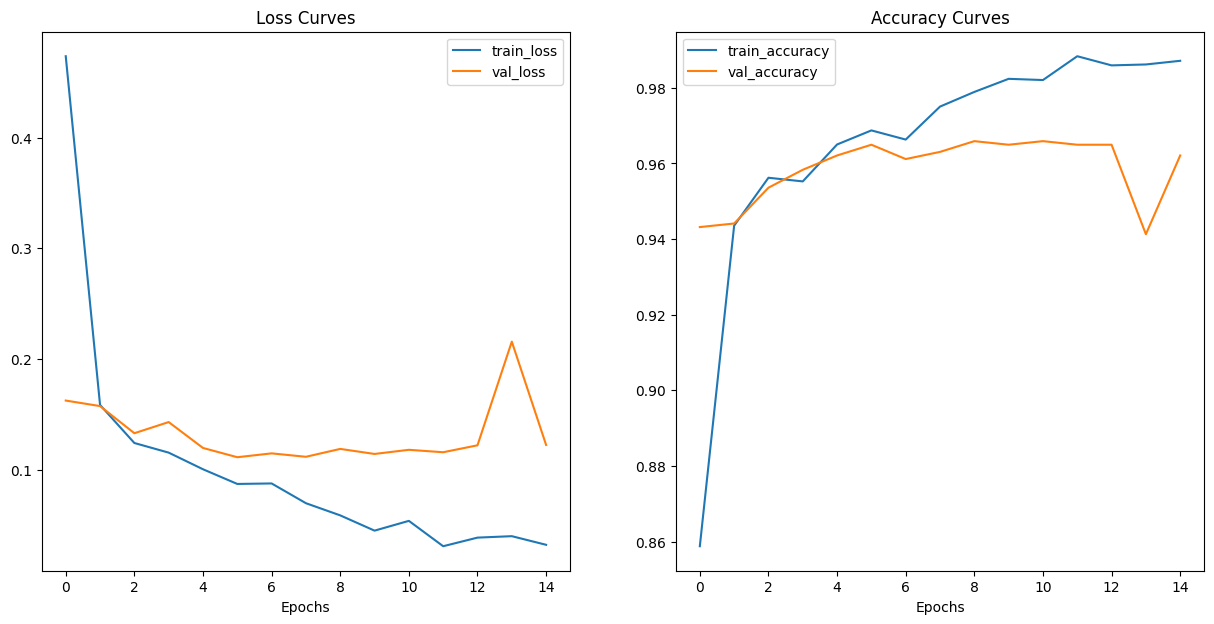

In [31]:
custom_cnn_results = custom_model_results

def plot_loss_curves(results: dict[str, list[float]]):

    loss = results['train_loss']
    val_loss = results['val_loss']
    accuracy = results['train_acc']
    val_accuracy = results['val_acc']
    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.legend()

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()

plot_loss_curves(custom_cnn_results)

In [32]:
def evaluation_metrics_report(model: torch.nn.Module,
                              dataloader: torch.utils.data.DataLoader,
                              class_names: list[str],
                              device: torch.device):

    model.eval()
    y_true_list = []
    y_preds_list = []

    with torch.inference_mode():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            y_pred_labels = torch.argmax(y_logits, dim=1)

            y_true_list.append(y.cpu())
            y_preds_list.append(y_pred_labels.cpu())

    y_true = torch.cat(y_true_list).numpy()
    y_preds = torch.cat(y_preds_list).numpy()

    report_dict = classification_report(y_true,
                                        y_preds,
                                        target_names=class_names,
                                        output_dict=True,
                                        zero_division=0)

    df_report = pd.DataFrame(report_dict).T.round(4)

    return df_report, y_true, y_preds

loaded_model_custom = CustomCNN(num_classes=NUM_CLASSES).to(device)
loaded_model_custom.load_state_dict(torch.load(MODEL_PATH))

df_report_custom, _, _ = evaluation_metrics_report(
    model=loaded_model_custom,
    dataloader=test_loader,
    class_names=class_names,
    device=device
)

print("\nCustom CNN")
print(df_report_custom)

  0%|          | 0/41 [00:00<?, ?it/s]


Custom CNN
              precision  recall  f1-score    support
COVID19          1.0000  0.9483    0.9735   116.0000
NORMAL           0.8889  0.9590    0.9226   317.0000
PNEUMONIA        0.9809  0.9591    0.9698   855.0000
accuracy         0.9581  0.9581    0.9581     0.9581
macro avg        0.9566  0.9554    0.9553  1288.0000
weighted avg     0.9599  0.9581    0.9585  1288.0000


# Model 2: Feature Extraction with a Pre-trained ResNet-18

For the second model, we'll use a pre-trained ResNet-18. We start by loading the model with its ImageNet weights, freezing all its layers, and then replacing the final classifier layer with one suited for our 3 classes. This technique is known as Feature Extraction.

## Load model

In [33]:
model_fe = models.resnet18(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 199MB/s]


## Freeze convolutional layers and replace classifier

In [34]:
for param in model_fe.parameters():
    param.requires_grad = False

num_ftrs = model_fe.fc.in_features

model_fe.fc = nn.Linear(in_features=num_ftrs, out_features=NUM_CLASSES)

model_fe = model_fe.to(device)

## Training

In [37]:
optimizer_fe = optim.Adam(params=model_fe.parameters(), lr=0.001)
# same loss function

NUM_EPOCHS_FE = 10
start_time_fe = time.time()

model_fe_results = train(model=model_fe,
                         train_dataloader=train_loader,
                         val_dataloader=val_loader,
                         optimizer=optimizer_fe,
                         loss_fn=loss_fn,
                         epochs=NUM_EPOCHS_FE,
                         device=device)

end_time_fe = time.time()

total_time_fe = end_time_fe - start_time_fe
print(f"Training last {total_time_fe:.2f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Época: 1 | Train loss: 0.4314 | Train acc: 0.8285 | Val loss: 0.2657 | Val acc: 0.9049
Época: 2 | Train loss: 0.2490 | Train acc: 0.9110 | Val loss: 0.2159 | Val acc: 0.9242
Época: 3 | Train loss: 0.2239 | Train acc: 0.9172 | Val loss: 0.1931 | Val acc: 0.9318
Época: 4 | Train loss: 0.1867 | Train acc: 0.9358 | Val loss: 0.1912 | Val acc: 0.9375
Época: 5 | Train loss: 0.1880 | Train acc: 0.9318 | Val loss: 0.1799 | Val acc: 0.9384
Época: 6 | Train loss: 0.1747 | Train acc: 0.9360 | Val loss: 0.1728 | Val acc: 0.9441
Época: 7 | Train loss: 0.1704 | Train acc: 0.9360 | Val loss: 0.1686 | Val acc: 0.9422
Época: 8 | Train loss: 0.1634 | Train acc: 0.9415 | Val loss: 0.1822 | Val acc: 0.9337


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7835cdc89b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Época: 9 | Train loss: 0.1539 | Train acc: 0.9429 | Val loss: 0.1938 | Val acc: 0.9299


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7835cdc89b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7835cdc89b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Época: 10 | Train loss: 0.1553 | Train acc: 0.9428 | Val loss: 0.1620 | Val acc: 0.9479
Training last 780.40 seconds


In [38]:
MODEL_FE_PATH = "models/resnet18_feature_extraction.pth"
torch.save(obj=model_fe.state_dict(), f=MODEL_FE_PATH)

## Evaluate performance

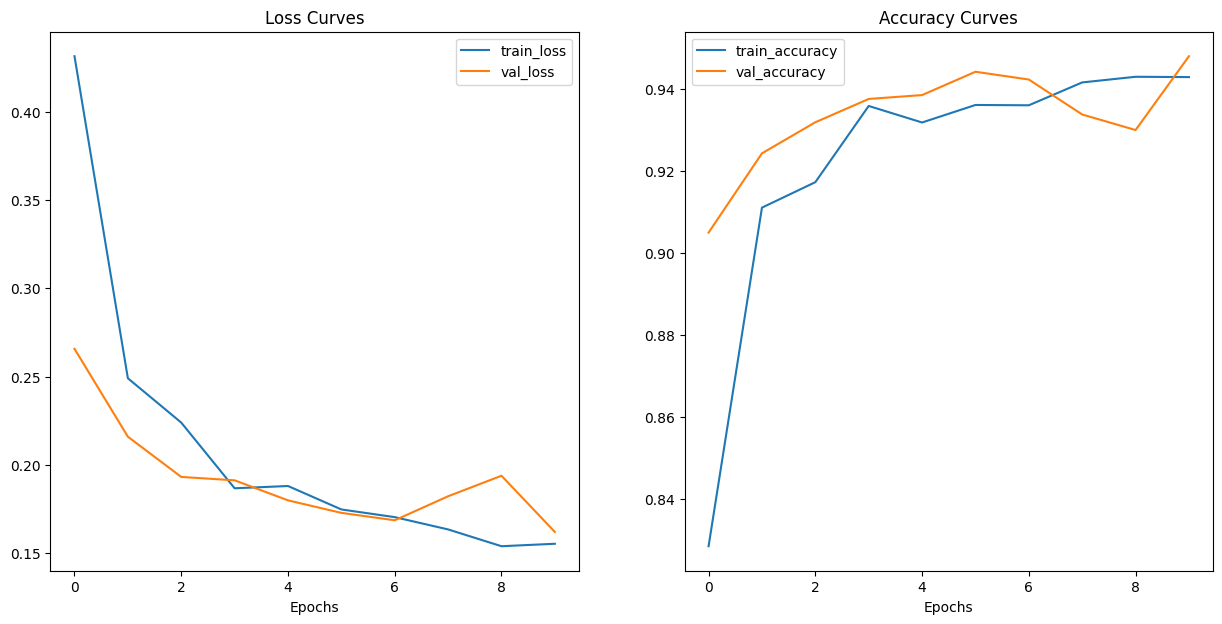

In [39]:
plot_loss_curves(model_fe_results)

In [40]:
loaded_model_fe = models.resnet18()
num_ftrs_fe = loaded_model_fe.fc.in_features
loaded_model_fe.fc = nn.Linear(num_ftrs_fe, NUM_CLASSES)
loaded_model_fe.to(device)

loaded_model_fe.load_state_dict(torch.load(MODEL_FE_PATH))

df_report_fe, _, _ = evaluation_metrics_report(
    model=loaded_model_fe,
    dataloader=test_loader,
    class_names=class_names,
    device=device
)

print("\nFeature Extraction")
print(df_report_fe)

  0%|          | 0/41 [00:00<?, ?it/s]


Feature Extraction
              precision  recall  f1-score    support
COVID19          0.9906  0.9052    0.9459   116.0000
NORMAL           0.8816  0.8927    0.8871   317.0000
PNEUMONIA        0.9477  0.9544    0.9510   855.0000
accuracy         0.9348  0.9348    0.9348     0.9348
macro avg        0.9400  0.9174    0.9280  1288.0000
weighted avg     0.9353  0.9348    0.9349  1288.0000


# Model 3: Fine-Tuning the Pre-trained ResNet-18

The final approach is fine-tuning. We will again load a pre-trained ResNet-18 and replace its classifier. However, this time we will unfreeze all the layers and train the entire network with a very low learning rate to adapt its learned features to our X-ray dataset.

### Load model

In [41]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")

num_ftrs_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(in_features=num_ftrs_ft, out_features=NUM_CLASSES)
model_ft = model_ft.to(device)

### Training

In [43]:
optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=0.0001)
# same loss function

NUM_EPOCHS_FT = 5

start_time_ft = time.time()

model_ft_results = train(model=model_ft,
                         train_dataloader=train_loader,
                         val_dataloader=val_loader,
                         optimizer=optimizer_ft,
                         loss_fn=loss_fn,
                         epochs=NUM_EPOCHS_FT,
                         device=device)

end_time_ft = time.time()

total_time_ft = end_time_ft - start_time_ft
print(f"Training last {total_time_ft:.2f} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

Época: 1 | Train loss: 0.2036 | Train acc: 0.9267 | Val loss: 0.1003 | Val acc: 0.9655
Época: 2 | Train loss: 0.0493 | Train acc: 0.9821 | Val loss: 0.1213 | Val acc: 0.9574
Época: 3 | Train loss: 0.0368 | Train acc: 0.9879 | Val loss: 0.0839 | Val acc: 0.9754
Época: 4 | Train loss: 0.0236 | Train acc: 0.9937 | Val loss: 0.0974 | Val acc: 0.9716
Época: 5 | Train loss: 0.0115 | Train acc: 0.9964 | Val loss: 0.0883 | Val acc: 0.9754
Training last 404.34 seconds.


In [44]:
MODEL_FT_PATH = "models/resnet18_fine_tuning.pth"
torch.save(obj=model_ft.state_dict(), f=MODEL_FT_PATH)

## Evaluate performance

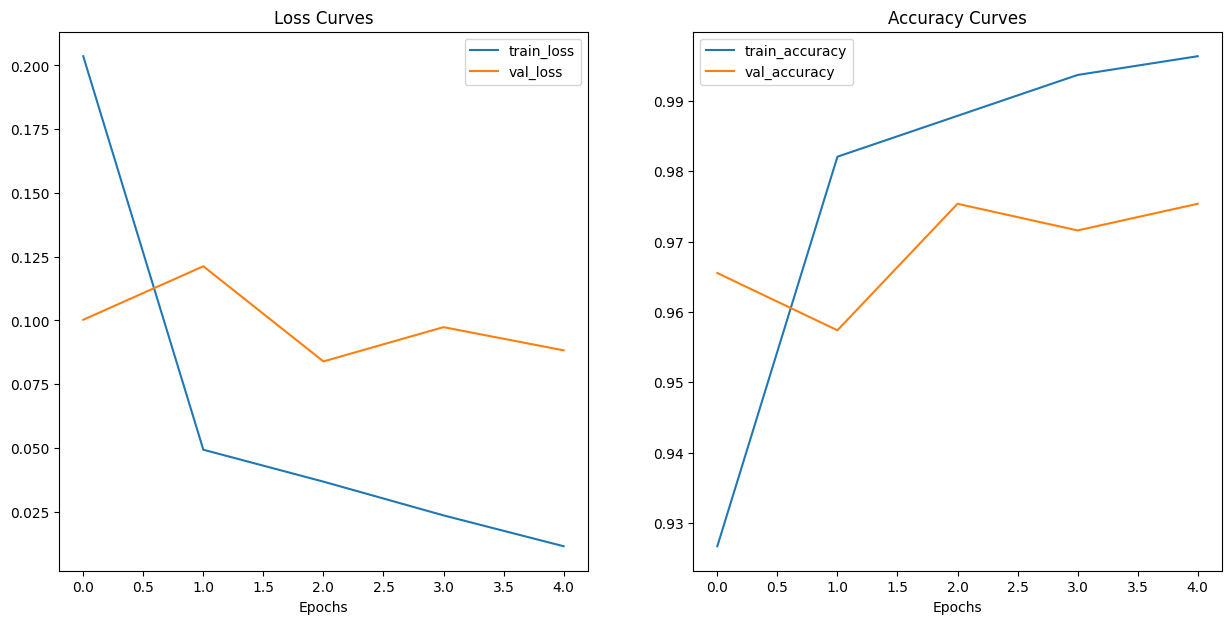

In [45]:
plot_loss_curves(model_ft_results)

In [46]:
loaded_model_ft = models.resnet18()
num_ftrs_ft = loaded_model_ft.fc.in_features
loaded_model_ft.fc = nn.Linear(num_ftrs_ft, NUM_CLASSES)
loaded_model_ft.to(device)

loaded_model_ft.load_state_dict(torch.load(MODEL_FT_PATH))

df_report_ft, y_true_ft, y_preds_ft = evaluation_metrics_report(
    model=loaded_model_ft,
    dataloader=test_loader,
    class_names=class_names,
    device=device
)

print("\nAvaliação Fine-Tuning")
print(df_report_ft)

  0%|          | 0/41 [00:00<?, ?it/s]


Avaliação Fine-Tuning
              precision  recall  f1-score    support
COVID19          1.0000  0.9224    0.9596   116.0000
NORMAL           0.9453  0.9274    0.9363   317.0000
PNEUMONIA        0.9690  0.9860    0.9774   855.0000
accuracy         0.9658  0.9658    0.9658     0.9658
macro avg        0.9714  0.9453    0.9578  1288.0000
weighted avg     0.9659  0.9658    0.9657  1288.0000


# Final Model Comparison

| Model | Accuracy | Precision (Macro) | Recall (Macro) | F1-Score (Macro) |
| :--- | :---: | :---: | :---: | :---: |
| Custom CNN | 0.9581|	0.9566|	0.9554|	0.9553|
| Feature Extraction | 0.9348|	0.9400|	0.9174|	0.9280|
| **Fine-Tuning (ResNet-18)** |  **0.9658**|	**0.9714**	|**0.9453**|	**0.9578**|

As shown in the table, the fine-tuned ResNet-18 model achieved the best performance across all metrics. The detailed analysis and discussion can be found in the project's README.md.